In [18]:
from keras import Input, layers, backend, Model, losses, datasets, models, metrics, optimizers, initializers
from keras.utils import Sequence
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import math

In [19]:

class FelixSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        """Here self.x is a list of paths to .npy input files. self.y is a
        corresponding list of paths to .npy output files."""
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        #print(np.array([np.load(file_name) for file_name in batch_x]).shape, np.array([np.load(file_name) for file_name in batch_y]).shape)
        return np.array([np.reshape(np.load(file_name), (128, 128, 1)) for file_name in batch_x]), np.array([np.reshape(np.load(file_name), (128, 128, 1)) for file_name in batch_y])
    

def gen_paths_labels(base_path = "D:\\Uni Work\\Masters Project\\electron_dists\\Data\\VAE_000_1\\Data"):
    """A generator to yield (data-paths, corresponding labels) tuples for each
    segment of data (typically training, validation, and testing)."""
    for segment in sorted(os.listdir(base_path)):
        segment_path = os.path.join(base_path, segment)
        input_paths = []
        output_paths = []
        for crystal in os.listdir(segment_path):
            crystal_path = os.path.join(segment_path, crystal)
            files = sorted(os.listdir(crystal_path))
            input_paths.append(os.path.join(crystal_path, files[0]))
            output_paths.append(os.path.join(crystal_path, files[1]))
        yield [input_paths, output_paths]

def gen_paths_fromfile(Path):
    input_paths = []
    output_paths = []
    with open(Path) as textFile:
        lines = [line.split() for line in textFile]
    #print(lines)
    for i in lines:
        output_paths.append(i[0])
        input_paths.append(i[0].split("Output.npy")[0] + "Input.npy")
    return([input_paths, output_paths])

In [20]:
latent_dim = 10

"""
## Create a sampling layer
"""
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [21]:
"""
## Build the encoder
"""
encoder_inputs = Input(shape=(128, 128, 1))
x = layers.Conv2D(32, kernel_size = (8, 8), activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, kernel_size = (8, 8), activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
#x = layers.Dropout(0.25)(x) #APPARANTLY THEY ARE BAD
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var", kernel_initializer='zeros', bias_initializer='zeros')(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 64, 64, 32)   2080        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 64)   131136      conv2d_4[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 65536)        0           conv2d_5[0][0]                   
____________________________________________________________________________________________

In [22]:
"""
## Build the decoder
"""


latent_inputs = Input(shape=(latent_dim,))
x = layers.Dense(32 * 32 * 64, activation="relu")(latent_inputs)
#x = layers.Dropout(0.25)(x)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(128, kernel_size = (8, 8), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, kernel_size = (8, 8), activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, kernel_size = (2, 2), activation="relu", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 65536)             720896    
_________________________________________________________________
reshape_2 (Reshape)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 64, 64, 128)       524416    
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 128, 128, 64)      524352    
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 128, 128, 1)       257       
Total params: 1,769,921
Trainable params: 1,769,921
Non-trainable params: 0
_________________________________________________

In [23]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                losses.mean_squared_logarithmic_error(y, reconstruction), axis=(1, 2)
                )
            )
            #print(z_mean, z_log_var, z)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    def call(self, data):
        return self.decoder(self.encoder(data)[2])

#losses.MSE(y, reconstruction), axis=(1, 2)
#losses.mean_squared_logarithmic_error(y, reconstruction), axis=(1, 2)

In [24]:
#vae = models.load_model("/home/ug-ml/felix-ML/VAE_000/Data/Models/VAE_3")

vae = VAE(encoder, decoder)
#vae.add_metric(trainable_metric(vae), name="testMetric")
vae.compile(optimizer=optimizers.Adam())


batch_size=64
#data_path = "/home/ug-ml/felix-ML/VAE_000/Data/FilePaths/"
data_path = "/home/ug-ml/felix-ML/VAE_000/Data/Data/"

data = [i for i in gen_paths_labels(data_path)]

val_seq = FelixSequence(data[2][0], data[2][1], batch_size)
train_seq = FelixSequence(data[1][0], data[1][1], batch_size)
test_seq = FelixSequence(data[0][0], data[0][1], batch_size)

#ValidationPaths = gen_paths_fromfile(data_path + "Validation_50.txt")
#TrainingPaths = gen_paths_fromfile(data_path + "Training_50.txt")
#TestPaths = gen_paths_fromfile(data_path + "Test_50.txt")

#val_seq = FelixSequence(ValidationPaths[0], ValidationPaths[1], batch_size)
#train_seq = FelixSequence(TrainingPaths[0], TrainingPaths[1], batch_size)
#test_seq = FelixSequence(TestPaths[0], TestPaths[1], batch_size)

#vae.fit(train_seq, shuffle=True, workers=16, epochs=1500)

epochs = 1500
patience = 20


patience_i = 0
best_val_loss = np.inf

#training and validation histories, containing [0] the total loss, [1] the reconstruction loss, and [2] the kl loss.
val_hist = np.zeros(shape=(1,epochs))
train_hist = np.zeros(shape=(3,epochs))

for epoch in range(0, epochs):
    print("-------------------------------------------------------------------------")
    print("Epoch", epoch, "/", epochs, ": ")
    print("Training: ")
    hist = vae.fit(x = train_seq, shuffle=True, epochs = epoch+1, workers = 16, initial_epoch=epoch)
    train_hist[0][epoch] = hist.history["loss"][0]
    train_hist[1][epoch] = hist.history["reconstruction_loss"][0]
    train_hist[2][epoch] = hist.history["kl_loss"][0]
    print("Validation: ")

    tot_batch_recon_loss = 0
    count = 0
    for x, y in val_seq:
        #rint(x.shape, y.shape)
        count += 1
        reconstruction = vae(x)
        reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                losses.mean_squared_logarithmic_error(y, reconstruction), axis=(1, 2)
                )
            )
        tot_batch_recon_loss += reconstruction_loss
        #print(batch_log_loss)
    
    avg_recon_loss = float(tot_batch_recon_loss/count)
    if(avg_recon_loss < best_val_loss):
        print("The model improved from: ",best_val_loss, "to: ", avg_recon_loss)
        best_val_loss = avg_recon_loss
        patience_i = 0
    else:
        patience_i+=1
        print("The model did not improve, patience_i = ", patience_i)
        
    print("Average reconstruction loss: ", avg_recon_loss)
    val_hist[0][epoch] = avg_recon_loss
    if(patience_i > patience):
        print("Early Stopping, the model did not improve from: ", best_val_loss)
        break

print("-------------------------------------------------------------------------")
print("Testing: ")
loss = vae.evaluate(test_seq)
print("loss: "+str(loss))



-------------------------------------------------------------------------
Epoch 0 / 1500 : 
Training: 
91/91 [==============================] - 11s 126ms/step - loss: 645.8847 - reconstruction_loss: 525.1106 - kl_loss: 1.4681
Validation: 
The model improved from:  inf to:  440.5650634765625
Average reconstruction loss:  440.5650634765625
-------------------------------------------------------------------------
Epoch 1 / 1500 : 
Training: 
Epoch 2/2
91/91 [==============================] - 11s 124ms/step - loss: 437.8586 - reconstruction_loss: 410.1732 - kl_loss: 6.9276
Validation: 
The model improved from:  440.5650634765625 to:  361.2657470703125
Average reconstruction loss:  361.2657470703125
-------------------------------------------------------------------------
Epoch 2 / 1500 : 
Training: 
Epoch 3/3
91/91 [==============================] - 11s 124ms/step - loss: 376.1705 - reconstruction_loss: 357.5217 - kl_loss: 11.0030
Validation: 
The model improved from:  361.2657470703125 to

91/91 [==============================] - 11s 123ms/step - loss: 162.2663 - reconstruction_loss: 139.2628 - kl_loss: 21.7662
Validation: 
The model improved from:  179.01927185058594 to:  171.7096405029297
Average reconstruction loss:  171.7096405029297
-------------------------------------------------------------------------
Epoch 22 / 1500 : 
Training: 
Epoch 23/23
91/91 [==============================] - 11s 124ms/step - loss: 152.7108 - reconstruction_loss: 132.1593 - kl_loss: 21.9483
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  173.44056701660156
-------------------------------------------------------------------------
Epoch 23 / 1500 : 
Training: 
Epoch 24/24
91/91 [==============================] - 11s 124ms/step - loss: 147.8179 - reconstruction_loss: 127.8847 - kl_loss: 22.0692
Validation: 
The model improved from:  171.7096405029297 to:  169.8755340576172
Average reconstruction loss:  169.8755340576172
----------------------------------

91/91 [==============================] - 11s 123ms/step - loss: 89.9468 - reconstruction_loss: 67.6825 - kl_loss: 22.0926
Validation: 
The model improved from:  135.2926025390625 to:  133.54351806640625
Average reconstruction loss:  133.54351806640625
-------------------------------------------------------------------------
Epoch 67 / 1500 : 
Training: 
Epoch 68/68
91/91 [==============================] - 11s 123ms/step - loss: 89.5994 - reconstruction_loss: 67.4862 - kl_loss: 22.1962
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  135.70277404785156
-------------------------------------------------------------------------
Epoch 68 / 1500 : 
Training: 
Epoch 69/69
91/91 [==============================] - 11s 124ms/step - loss: 92.5657 - reconstruction_loss: 72.0702 - kl_loss: 22.2416
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  140.45431518554688
--------------------------------------------------------------

91/91 [==============================] - 11s 124ms/step - loss: 79.7868 - reconstruction_loss: 58.7998 - kl_loss: 22.0940
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  132.58197021484375
-------------------------------------------------------------------------
Epoch 91 / 1500 : 
Training: 
Epoch 92/92
91/91 [==============================] - 11s 124ms/step - loss: 79.9174 - reconstruction_loss: 58.2680 - kl_loss: 22.0668
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  129.85147094726562
-------------------------------------------------------------------------
Epoch 92 / 1500 : 
Training: 
Epoch 93/93
91/91 [==============================] - 11s 124ms/step - loss: 79.5840 - reconstruction_loss: 58.4961 - kl_loss: 21.9971
Validation: 
The model improved from:  128.71092224121094 to:  127.72473907470703
Average reconstruction loss:  127.72473907470703
-------------------------------------------------------------

91/91 [==============================] - 11s 124ms/step - loss: 69.3911 - reconstruction_loss: 47.3214 - kl_loss: 21.2613
Validation: 
The model did not improve, patience_i =  12
Average reconstruction loss:  129.5850067138672
-------------------------------------------------------------------------
Epoch 137 / 1500 : 
Training: 
Epoch 138/138
91/91 [==============================] - 11s 123ms/step - loss: 69.7954 - reconstruction_loss: 47.5680 - kl_loss: 21.3098
Validation: 
The model did not improve, patience_i =  13
Average reconstruction loss:  125.93486022949219
-------------------------------------------------------------------------
Epoch 138 / 1500 : 
Training: 
Epoch 139/139
91/91 [==============================] - 11s 125ms/step - loss: 66.6018 - reconstruction_loss: 45.8883 - kl_loss: 21.1889
Validation: 
The model did not improve, patience_i =  14
Average reconstruction loss:  127.62324523925781
-------------------------------------------------------------------------
Epoch

The model did not improve, patience_i =  2
Average reconstruction loss:  124.66610717773438
-------------------------------------------------------------------------
Epoch 160 / 1500 : 
Training: 
Epoch 161/161
91/91 [==============================] - 11s 124ms/step - loss: 62.4881 - reconstruction_loss: 42.4132 - kl_loss: 20.4923
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  121.572998046875
-------------------------------------------------------------------------
Epoch 161 / 1500 : 
Training: 
Epoch 162/162
91/91 [==============================] - 11s 124ms/step - loss: 62.5211 - reconstruction_loss: 42.4382 - kl_loss: 20.4892
Validation: 
The model improved from:  121.14743041992188 to:  121.1059341430664
Average reconstruction loss:  121.1059341430664
-------------------------------------------------------------------------
Epoch 162 / 1500 : 
Training: 
Epoch 163/163
91/91 [==============================] - 11s 124ms/step - loss: 61.3572 - r

91/91 [==============================] - 11s 124ms/step - loss: 59.7357 - reconstruction_loss: 40.7279 - kl_loss: 20.3716
Validation: 
The model did not improve, patience_i =  21
Average reconstruction loss:  122.2955322265625
Early Stopping, the model did not improve from:  120.92373657226562
-------------------------------------------------------------------------
Testing: 
6/6 [==============================] - 0s 48ms/step - total_loss: 0.0000e+00 - reconstruction_loss: 0.0000e+00 - kl_loss: 0.0000e+00
loss: [0.0, 0.0, 0.0]


In [17]:
vae.save("/home/ug-ml/felix-ML/VAE_000/Data/Models/VAE_5")


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/VAE_5/assets


In [ ]:
#vae = models.load_model("/home/ug-ml/felix-ML/VAE_000/Data/Models/VAE_3")

Log loss is:  627.7399378178378


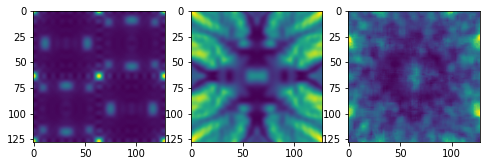

Log loss is:  678.9403472921865


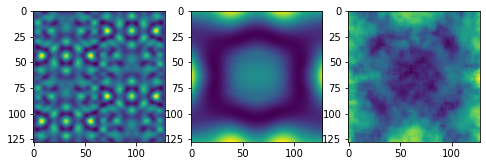

Log loss is:  555.5723592748539


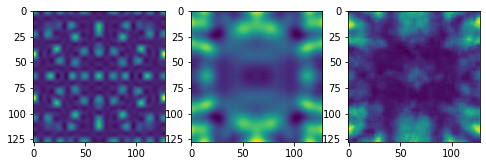

Log loss is:  518.3709702910387


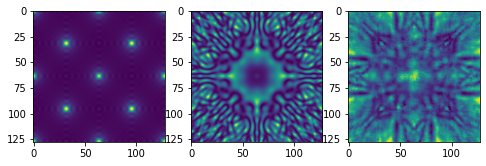

Log loss is:  634.3377242178199


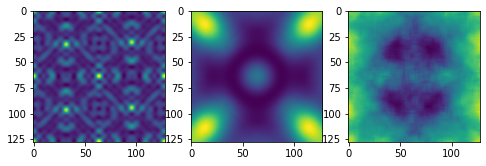

Log loss is:  624.8040354244147


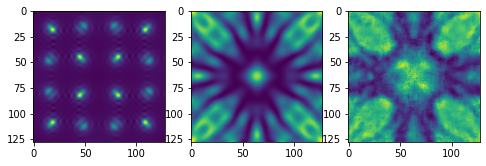

Log loss is:  1073.5020615260808


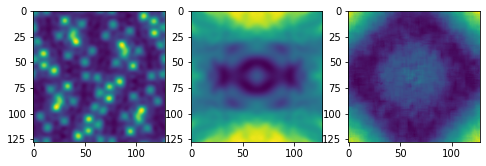

Log loss is:  758.9961697597339


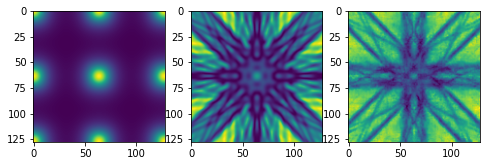

Log loss is:  808.8195614000875


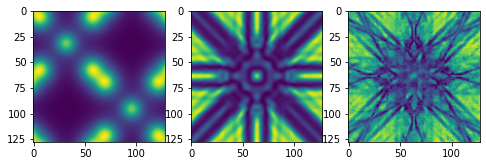

Log loss is:  709.0631470949646


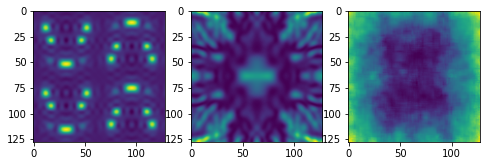

Log loss is:  627.4926116048615


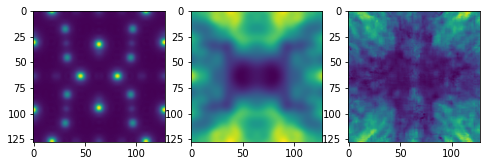

Log loss is:  1376.7000013311408


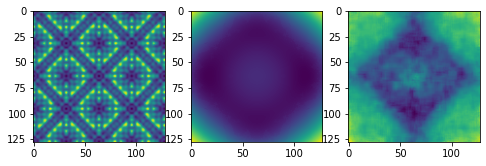

Log loss is:  532.4618318319964


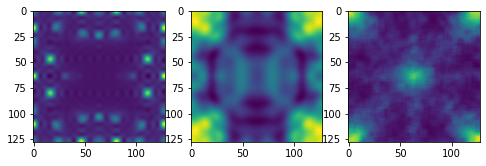

Log loss is:  523.4050452450936


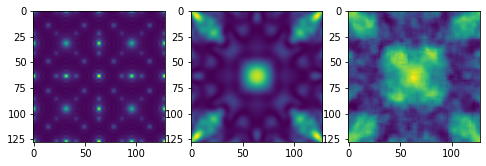

Log loss is:  825.2262358430294


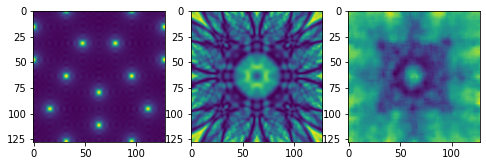

Log loss is:  1088.7847121828154


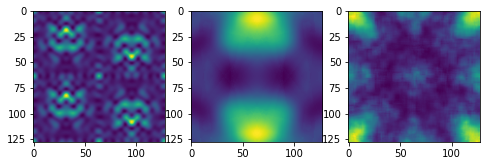

Log loss is:  1017.0015402131487


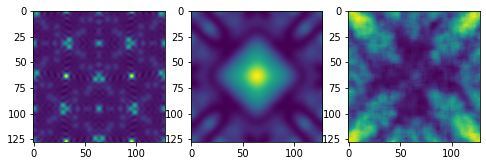

Average loss:  6490.609146175552


In [30]:
average_loss = 0
#data[0][0], data[0][1]
for i in range(0, len(data[0][0])):
    x = np.load(data[0][0][i])
    y = np.load(data[0][1][i])
    #x = np.load(data[0][i])
    #y = np.load(data[1][i])
    a = np.reshape(vae(np.reshape(x, (1, 128, 128, 1))), (128, 128))
    #print(TestPaths[0][i])
    log_loss = 0
    for j in range(0, a.shape[0]):
        for k in range(0, a.shape[1]):
            log_loss+=(math.log(1+a[j][k]) - math.log(1+y[j][k])) ** 2
    
    if log_loss > 500:
        print("Log loss is: ", log_loss)
        average_loss+=log_loss
        w=10
        h=10
        fig=plt.figure(figsize=(8, 8))
        columns = 3
        rows = 1
        fig.add_subplot(rows, columns, 1)
        plt.imshow(x)
        fig.add_subplot(rows, columns, 2)
        plt.imshow(y)
        fig.add_subplot(rows, columns, 3)
        plt.imshow(a)
        plt.show()
print("Average loss: ", average_loss / len(data[0]))

In [ ]:
for i in range(0, len(TrainingPaths[0])):
    #x = np.load(data[0][0][i])
    #y = np.load(data[0][1][i])
    x = np.load(TrainingPaths[0][i])
    y = np.load(TrainingPaths[1][i])
    a = np.reshape(vae(np.reshape(x, (1, 128, 128, 1))), (128, 128))
    print(TrainingPaths[0][i])

    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = 3
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(x)
    fig.add_subplot(rows, columns, 2)
    plt.imshow(y)
    fig.add_subplot(rows, columns, 3)
    plt.imshow(a)
    plt.show()